In [1]:
from pathlib import Path
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

file_name1 = 'I1_and_I2'
file_name2 = 'pulsation_ratio'

# Load data
DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name1}.pkl"
data1 = pd.read_pickle(DATA_PATH)
DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name2}.pkl"
data2 = pd.read_pickle(DATA_PATH)

# Load Configs
CONFIG_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name1}.json"
with open(CONFIG_PATH, "r") as f:
    config1 = json.load(f)
CONFIG_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name2}.json"
with open(CONFIG_PATH, "r") as f:
    config2 = json.load(f)
labels = config1["labels"]  # Should have the same labels
intensity = config1["features"]
pulsation_ratio = config2["features"]

data = pd.merge(data1, data2, on=labels, how="inner")

# Cleanup
data.dropna(inplace=True)

In [2]:
# Create the pathlength mean columns
pathlength_stats = Path(r'/home/rraiyan/simulations/tfo_sim/data/pathlength_stats/dan_iccps_pencil2.pkl')
pathlength_stats = pd.read_pickle(pathlength_stats)

l4_mean_column_names = list(filter(lambda x: 'L4 ppath_mean' in x, pathlength_stats.columns))
wv1_ppath = (pathlength_stats[pathlength_stats['Wave Int'] == 1])[['Maternal Wall Thickness'] + l4_mean_column_names]
wv2_ppath = (pathlength_stats[pathlength_stats['Wave Int'] == 2])[['Maternal Wall Thickness'] + l4_mean_column_names]
wv1_ppath.set_index(['Maternal Wall Thickness'], inplace=True)
wv2_ppath.set_index(['Maternal Wall Thickness'], inplace=True)
pathlength_stats.drop(columns=['Wave Int'], inplace=True)   # Don't need this column anymore

# Append the pathlength stats to the data
for column in wv1_ppath.columns:
    data[column + ' WV1'] = data['Maternal Wall Thickness'].map(wv1_ppath[column])
for column in wv2_ppath.columns:
    data[column + ' WV2'] = data['Maternal Wall Thickness'].map(wv2_ppath[column])

# Defining feature groups
wv1_pulsation_ratio = list(filter(lambda x: 'WV1' in x, pulsation_ratio))
wv2_pulsation_ratio = list(filter(lambda x: 'WV2' in x, pulsation_ratio))
wv1_intensity = list(filter(lambda x: '1.0' in x, intensity))
wv2_intensity = list(filter(lambda x: '2.0' in x, intensity))
wv1_ppath = [x + ' WV1' for x in l4_mean_column_names]  # Replace with the new column names
wv2_ppath = [x + ' WV2' for x in l4_mean_column_names]  # Replace with the new column names

# Pulsation Ratio copy (This will be left unscaled)
unscaled_pulsation_ratio_columns = [x + ' unscaled' for x in pulsation_ratio]
temp = data[pulsation_ratio]
temp.columns = unscaled_pulsation_ratio_columns
data = pd.concat([data, temp], axis=1)  # Avoids contiguity issues

# Calculate the BL term
from inverse_modelling_tfo.tools.optical_properties import get_tissue_mu_a

def calculate_mua0_wv2(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 1"], row["Fetal Saturation"], wave_int=2)
    return mu_a

def calculate_mua1_wv2(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 2"], row["Fetal Saturation"], wave_int=2)
    return mu_a

def calculate_mua0_wv1(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 1"], row["Fetal Saturation"], wave_int=1)
    return mu_a

def calculate_mua1_wv1(row):
    mu_a = get_tissue_mu_a(0.1, row["Fetal Hb Concentration 2"], row["Fetal Saturation"], wave_int=1)
    return mu_a

data["Fetal Mua 1 WV2"] = data.apply(calculate_mua0_wv2, axis=1)
data["Fetal Mua 2 WV2"] = data.apply(calculate_mua1_wv2, axis=1)
data["Fetal Mua 1 WV1"] = data.apply(calculate_mua0_wv1, axis=1)
data["Fetal Mua 2 WV1"] = data.apply(calculate_mua1_wv1, axis=1)

data["Delta Mu WV2"] = data["Fetal Mua 2 WV2"] - data["Fetal Mua 1 WV2"]
data["Delta Mu WV1"] = data["Fetal Mua 2 WV1"] - data["Fetal Mua 1 WV1"]

# Generate the BL columns
# Create an empty dataframe, fillup with BLs, concat back into original, this way avoids data contiguity issues
bl_column_names = [f'{column}_BL WV1' for column in l4_mean_column_names] + [f'{column}_BL WV2' for column in l4_mean_column_names]
unscaled_bl_df = pd.DataFrame(columns=bl_column_names)
for wv1_column, wv2_column, column in zip(wv1_ppath, wv2_ppath, l4_mean_column_names):
    unscaled_bl_df[f'{column}_BL WV1'] = data[wv1_column] * (data['Fetal Mua 2 WV1'] - data['Fetal Mua 1 WV1'])
    unscaled_bl_df[f'{column}_BL WV2'] = data[wv2_column] * (data['Fetal Mua 2 WV2'] - data['Fetal Mua 1 WV2'])
data = pd.concat([data, unscaled_bl_df], axis=1)
# Get the indices
bl_column_indices = [data.columns.get_loc(column) for column in bl_column_names]

In [3]:
l4_mean_column_names

['L4 ppath_mean_10',
 'L4 ppath_mean_15',
 'L4 ppath_mean_19',
 'L4 ppath_mean_24',
 'L4 ppath_mean_28',
 'L4 ppath_mean_33',
 'L4 ppath_mean_37',
 'L4 ppath_mean_41',
 'L4 ppath_mean_46',
 'L4 ppath_mean_50',
 'L4 ppath_mean_55',
 'L4 ppath_mean_59',
 'L4 ppath_mean_64',
 'L4 ppath_mean_68',
 'L4 ppath_mean_72',
 'L4 ppath_mean_77',
 'L4 ppath_mean_81',
 'L4 ppath_mean_86',
 'L4 ppath_mean_90',
 'L4 ppath_mean_94']

Text(0, 0.5, 'Mean Partial Pathlength (mm)')

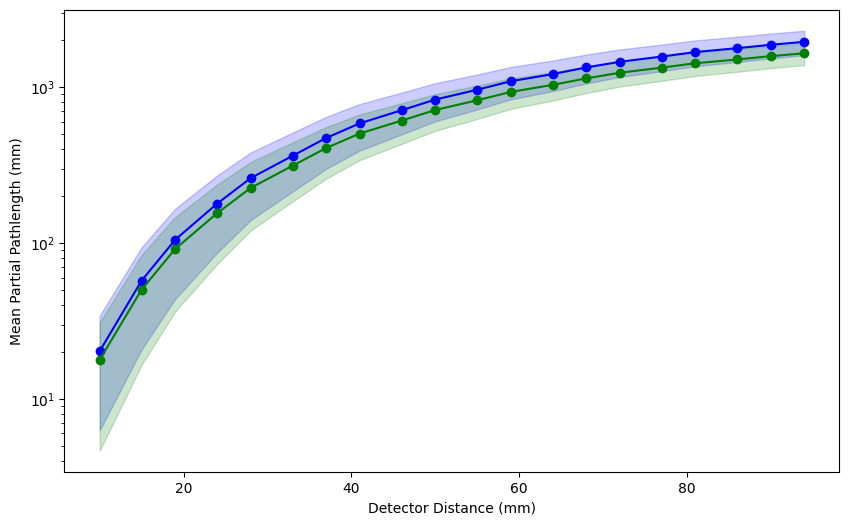

In [4]:
# Plotting The mean partial pathlengths for WV1 and WV2 against the detector distance
avg_L_fig = plt.figure(figsize=(10, 6))
wv1_means = []
wv2_means = []
wv1_stds = []
wv2_stds = []
detector_sdd = []
for wv1_column, wv2_column, column in zip(wv1_ppath, wv2_ppath, l4_mean_column_names):
    detector_sdd.append(float(column.split("_")[-1]))
    wv1_means.append(data[wv1_column].mean())
    wv2_means.append(data[wv2_column].mean())
    wv1_stds.append(data[wv1_column].std())
    wv2_stds.append(data[wv2_column].std())

# Convert to numpy arrays
detector_sdd = np.array(detector_sdd)
wv1_means = np.array(wv1_means)
wv2_means = np.array(wv2_means)
wv1_stds = np.array(wv1_stds)
wv2_stds = np.array(wv2_stds)


plt.plot(detector_sdd, wv1_means, label="735nm", marker='o', color='b')
plt.plot(detector_sdd, wv2_means, label="850nm", marker='o', color='g')


# Add variance as dotted lines around the mean line
plt.fill_between(detector_sdd, wv1_means - wv1_stds, wv1_means + wv1_stds, color="b", alpha=0.2)   # ignore error
plt.fill_between(detector_sdd, wv2_means - wv2_stds, wv2_means + wv2_stds, color="g", alpha=0.2)    # ignore error

plt.yscale("log")
plt.xlabel("Detector Distance (mm)")
plt.ylabel("Mean Partial Pathlength (mm)")

# Plotting the Error in BL Terms vs. Pulsation Ratio

In [5]:
data[unscaled_pulsation_ratio_columns].describe()

,MAX_ACbyDC_WV1_10 unscaled,MAX_ACbyDC_WV1_15 unscaled,MAX_ACbyDC_WV1_19 unscaled,MAX_ACbyDC_WV1_24 unscaled,MAX_ACbyDC_WV1_28 unscaled,MAX_ACbyDC_WV1_33 unscaled,MAX_ACbyDC_WV1_37 unscaled,MAX_ACbyDC_WV1_41 unscaled,MAX_ACbyDC_WV1_46 unscaled,MAX_ACbyDC_WV1_50 unscaled,...,MAX_ACbyDC_WV2_55 unscaled,MAX_ACbyDC_WV2_59 unscaled,MAX_ACbyDC_WV2_64 unscaled,MAX_ACbyDC_WV2_68 unscaled,MAX_ACbyDC_WV2_72 unscaled,MAX_ACbyDC_WV2_77 unscaled,MAX_ACbyDC_WV2_81 unscaled,MAX_ACbyDC_WV2_86 unscaled,MAX_ACbyDC_WV2_90 unscaled,MAX_ACbyDC_WV2_94 unscaled
count,5.155920e+05,5.155920e+05,5.155920e+05,5.155920e+05,5.155920e+05,5.155920e+05,5.155920e+05,5.155920e+05,5.155920e+05,5.155920e+05,...,5.155920e+05,5.155920e+05,5.155920e+05,5.155920e+05,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000,515592.000000
mean,1.411240e-06,2.079500e-05,8.298744e-05,2.874568e-04,6.532054e-04,1.185362e-03,1.681538e-03,2.131683e-03,2.546958e-03,2.998775e-03,...,6.915611e-03,7.656712e-03,8.579477e-03,9.665117e-03,0.010296,0.011990,0.011946,0.016533,0.013400,0.015443
std,6.157235e-06,7.589912e-05,2.900048e-04,9.506779e-04,1.976705e-03,3.112761e-03,3.805323e-03,4.197391e-03,4.414160e-03,4.640923e-03,...,7.388331e-03,7.509296e-03,7.477824e-03,7.783596e-03,0.007456,0.007352,0.007520,0.009174,0.007242,0.011274
min,-1.508303e-05,-8.960152e-06,-6.982284e-06,-5.011696e-06,-3.098321e-06,-2.637204e-06,-2.325826e-06,-1.621493e-06,-1.183809e-06,-1.594692e-06,...,-7.624620e-07,-2.001743e-07,9.177788e-07,6.343802e-07,0.000003,0.000022,0.000005,0.000008,0.000602,0.000373
25%,-1.195902e-06,-5.402421e-07,-2.858000e-07,-1.243190e-07,0.000000e+00,0.000000e+00,8.161837e-08,9.503569e-08,1.389132e-07,1.723762e-07,...,2.967559e-05,1.022060e-04,1.848932e-04,3.100306e-04,0.001247,0.002682,0.003796,0.013688,0.007661,0.009344
50%,2.797384e-07,4.183859e-07,4.454180e-07,5.132421e-07,5.312456e-07,7.013100e-07,1.498212e-06,3.436795e-06,9.647095e-06,2.111277e-05,...,2.618202e-03,5.040645e-03,9.100770e-03,1.118892e-02,0.013424,0.015145,0.015614,0.016369,0.014362,0.014700
75%,1.895443e-06,1.855118e-06,2.703167e-06,1.556565e-05,5.118604e-05,1.512909e-04,3.740069e-04,1.042571e-03,2.644357e-03,5.568535e-03,...,1.618429e-02,1.635803e-02,1.642850e-02,1.674891e-02,0.016519,0.016628,0.017194,0.021705,0.017538,0.018992
max,4.495940e-05,4.562211e-04,1.782363e-03,5.694496e-03,1.070699e-02,1.407152e-02,1.390435e-02,1.335820e-02,1.242934e-02,1.219905e-02,...,1.843262e-02,1.838897e-02,2.111086e-02,2.344441e-02,0.034191,0.030904,0.027948,0.053360,0.047227,0.075043


In [6]:
# Generating Pulsation Ratio
# Formula Used: log(I1) - log(I2)
I1_wv1 = list(filter(lambda x: x.endswith('_1') and '1.0' in x, intensity))
I1_wv2 = list(filter(lambda x: x.endswith('_1') and '2.0' in x, intensity))
I2_wv1 = list(filter(lambda x: x.endswith('_2') and '1.0' in x, intensity))
I2_wv2 = list(filter(lambda x: x.endswith('_2') and '2.0' in x, intensity))
# Sanity Check
print('Intensity Column Counts: ', len(I1_wv1), len(I1_wv2), len(I2_wv1), len(I2_wv2))

# Calculate the Pulsation Ratio -> absolute (Don't care about the sign)
pr_wv1 = np.abs(np.log(data[I1_wv1].to_numpy()) - np.log(data[I2_wv1].to_numpy()))
pr_wv2 = np.abs(np.log(data[I1_wv2].to_numpy()) - np.log(data[I2_wv2].to_numpy()))

# Sanity Check
print('Pulsation Ratio Shape: ', pr_wv1.shape, pr_wv2.shape)
nan_count_pr_wv1 = np.sum(np.isnan(pr_wv1))
nan_count_pr_wv2 = np.sum(np.isnan(pr_wv2))
print('NaN count in pr_wv1: ', nan_count_pr_wv1)
print('NaN count in pr_wv2: ', nan_count_pr_wv2)

# Capture the BL Law term's absolute value
bl_wv1 = data[list(filter(lambda x: x.endswith('BL WV1'), data.columns))].to_numpy()
bl_wv2 = data[list(filter(lambda x: x.endswith('BL WV2'), data.columns))].to_numpy()
bl_wv1 = np.abs(bl_wv1)
bl_wv2 = np.abs(bl_wv2)

# Sanity Check
print('BL Shape: ', bl_wv1.shape, bl_wv2.shape)
nan_count_bl_wv1 = np.sum(np.isnan(bl_wv1))
nan_count_bl_wv2 = np.sum(np.isnan(bl_wv2))
print('NaN count in bl_wv1: ', nan_count_bl_wv1)
print('NaN count in bl_wv2: ', nan_count_bl_wv2)

Intensity Column Counts:  20 20 20 20
Pulsation Ratio Shape:  (515592, 20) (515592, 20)
NaN count in pr_wv1:  0
NaN count in pr_wv2:  0
BL Shape:  (515592, 20) (515592, 20)
NaN count in bl_wv1:  0
NaN count in bl_wv2:  0


Error WV1 Mean:  1.172277382216381
Error WV2 Mean:  0.8232298963190428


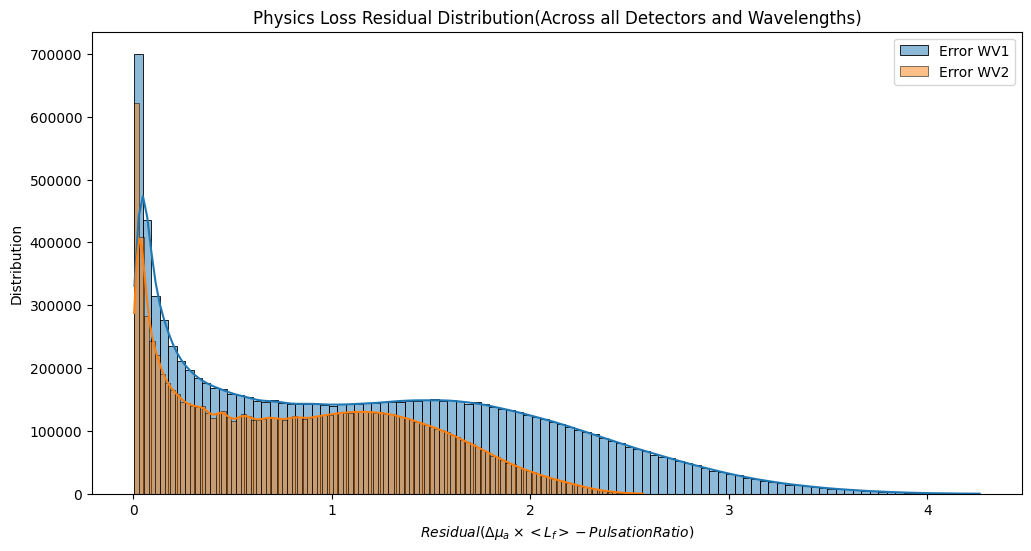

In [7]:
import seaborn as sns
# Calculate the Physics Loss Term per Wave Length
overall_loss_fig = plt.figure(figsize=(12, 6))
sns.histplot((bl_wv1 - pr_wv1).flatten(), bins=100, kde=True, label='Error WV1')
sns.histplot((bl_wv2 - pr_wv2).flatten(), bins=100, kde=True, label='Error WV2')
plt.legend()
plt.xlabel(r'$Residual(\Delta \mu_a \times <L_f> - Pulsation Ratio)$')
plt.ylabel('Distribution')
plt.title('Physics Loss Residual Distribution(Across all Detectors and Wavelengths)')
print("Error WV1 Mean: ", np.mean((bl_wv1 - pr_wv1).flatten()))
print("Error WV2 Mean: ", np.mean((bl_wv2 - pr_wv2).flatten()))

In [8]:
# Count the Zeroes in the error
zero_count_wv1 = np.sum((bl_wv1 - pr_wv1) <= 0.01)
zero_count_wv2 = np.sum((bl_wv2 - pr_wv2) <= 0.01)
print('Zero Count WV1: ', zero_count_wv1)
print('Zero Count WV2: ', zero_count_wv2)

Zero Count WV1:  86034
Zero Count WV2:  188447


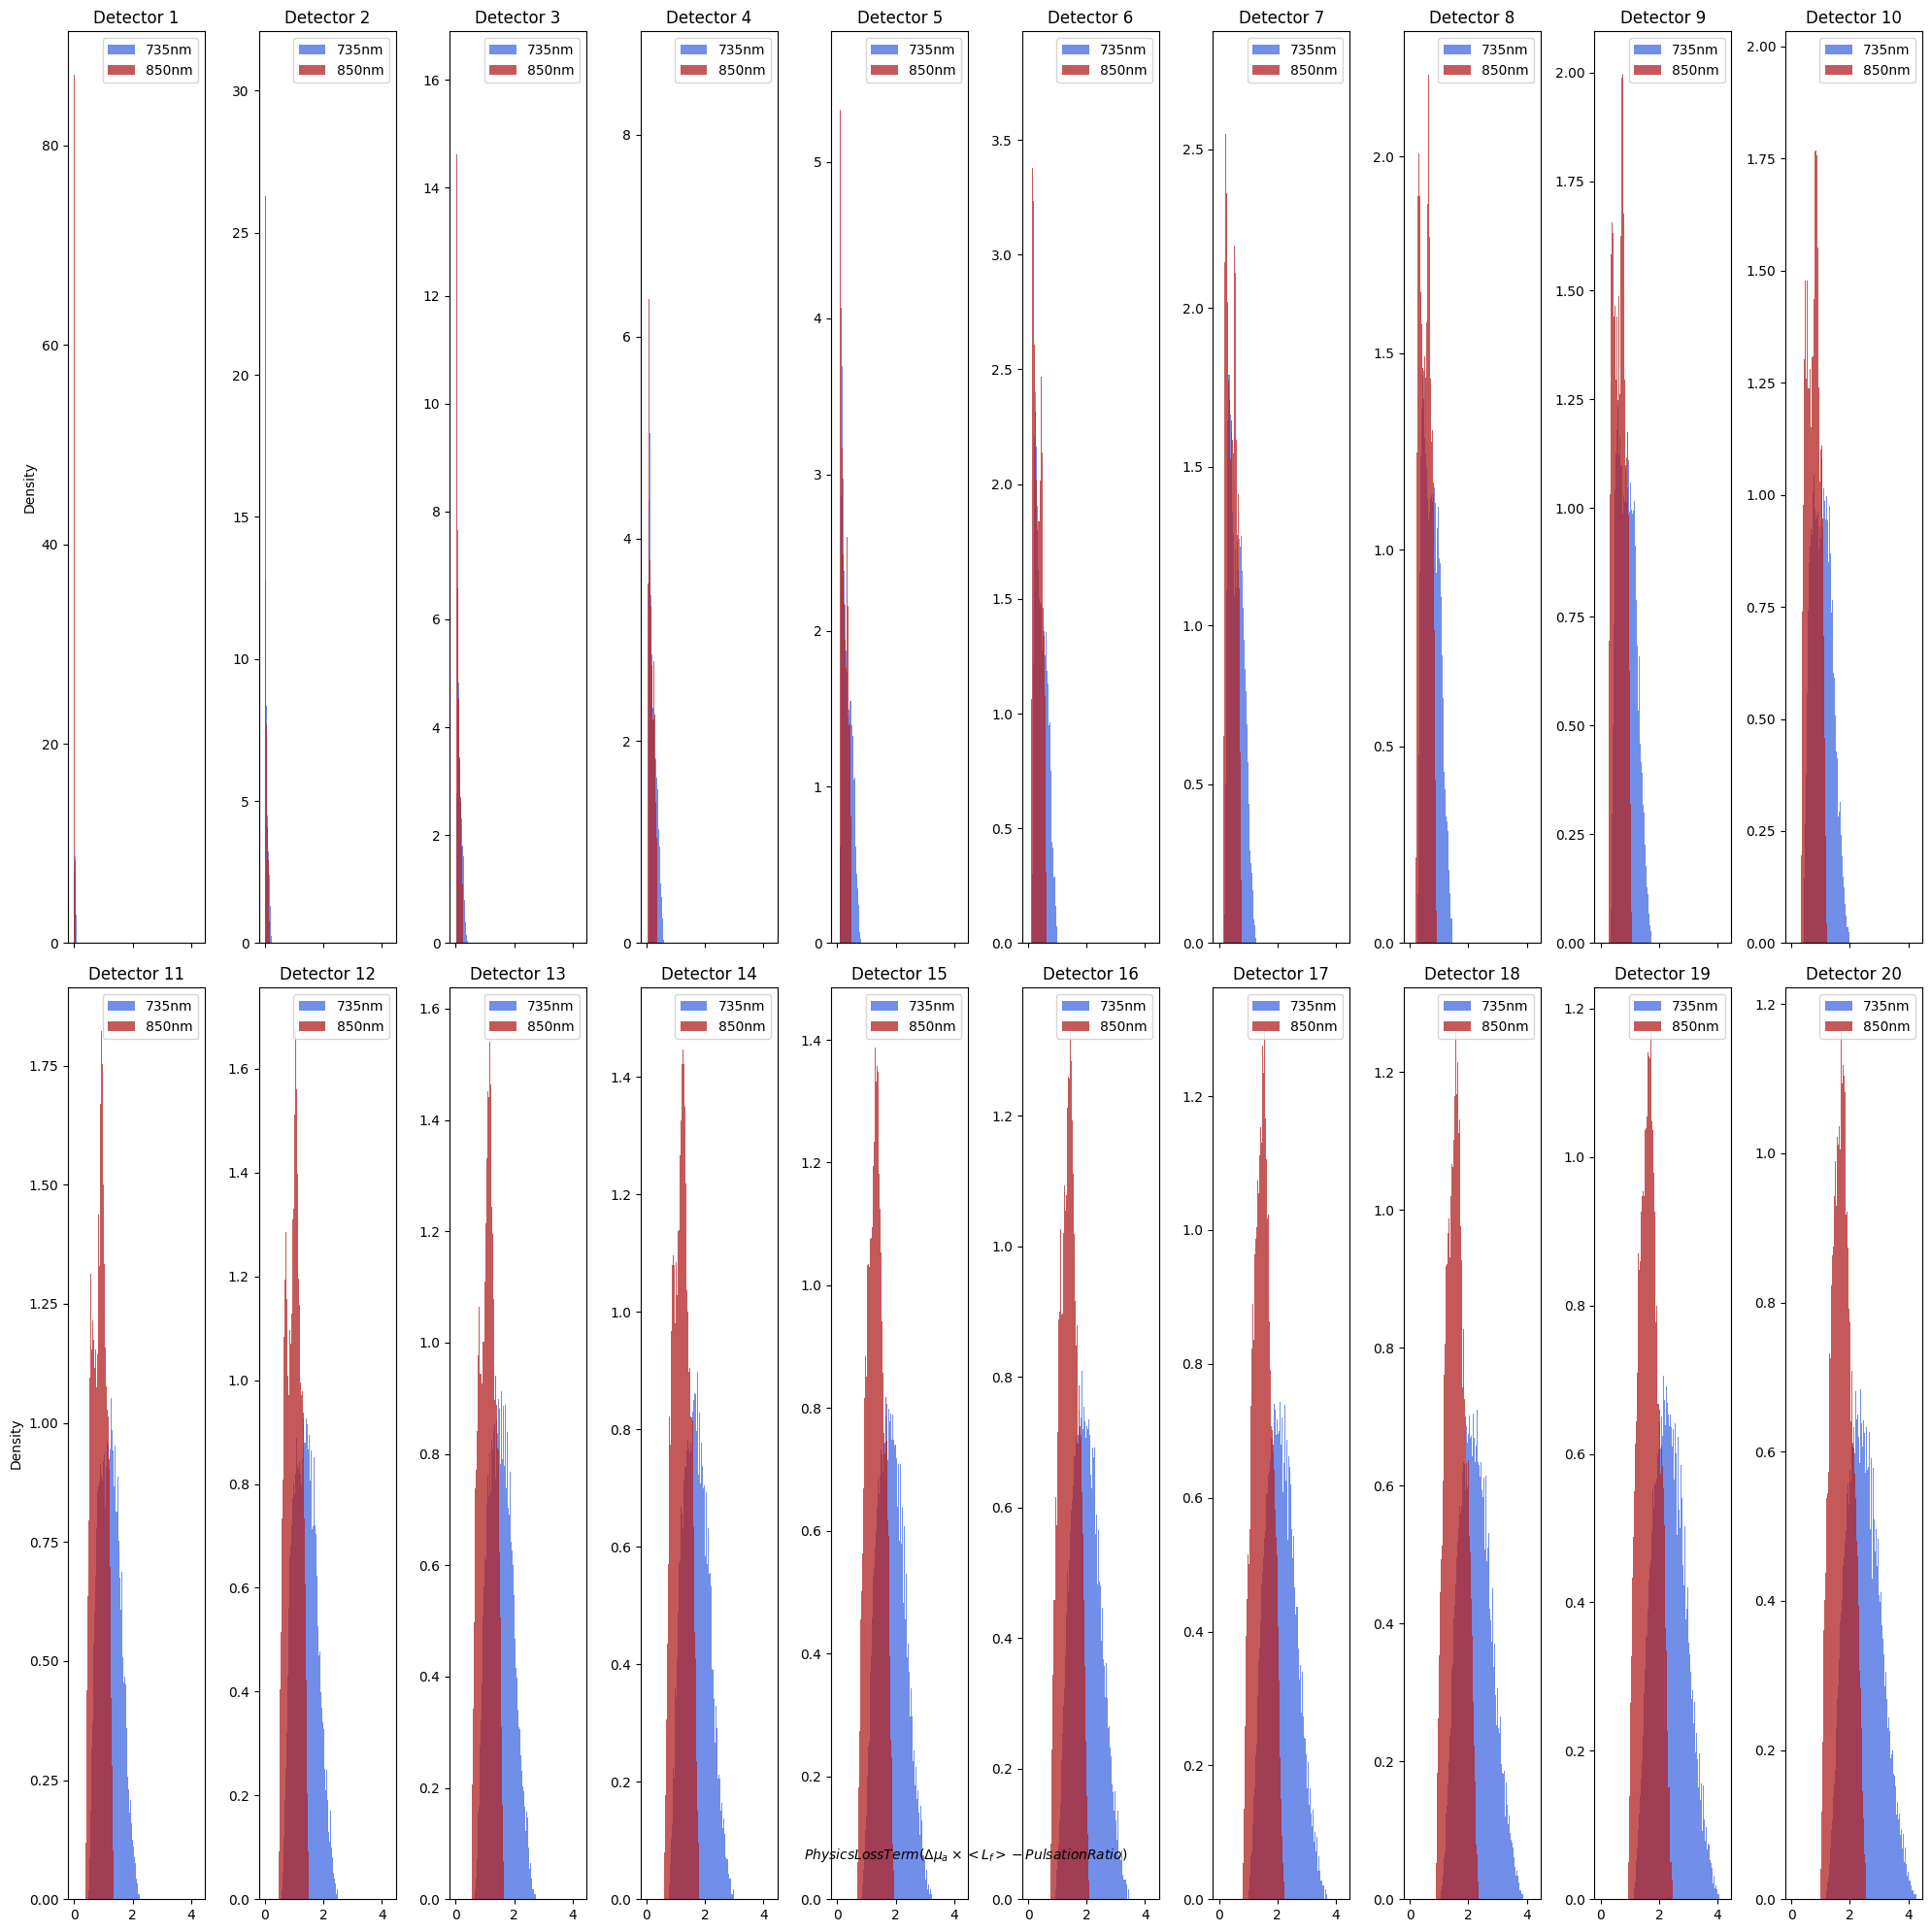

In [9]:
# Break down the same plot per detector/per wavelength
loss_breakdown_fig, axes = plt.subplots(2, 10, figsize=(20, 20), sharex=True)
for i, ax in enumerate(axes.flatten()):
    ax.hist((bl_wv1[:, i] - pr_wv1[:, i]), bins=100, density=True, alpha=0.75, color='royalblue', label='735nm')
    ax.hist((bl_wv2[:, i] - pr_wv2[:, i]), bins=100, density=True, alpha=0.75, color='firebrick', label='850nm')
    ax.set_title(f'Detector {i + 1}')
    ax.legend(loc='upper right')

# Place Legend
axes[0, 0].set_ylabel('Density')
axes[1, 0].set_ylabel('Density')
loss_breakdown_fig.text(0.5, 0.04, r'$Physics Loss Term(\Delta \mu_a \times <L_f> - Pulsation Ratio)$', ha='center')
plt.tight_layout()

In [10]:
# Filtering by depth
all_depths = data["Maternal Wall Thickness"].unique()
all_depths.sort()
print("Available Depths", all_depths)

Available Depths [ 4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21.
 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34.]


In [11]:
# Plotting the distributions for the chosen detector
def plot_depth_specific_distribution(chosen_detector_column_index: int):
    depth_effect_fig, axes = plt.subplots(2, len(all_depths) // 2, figsize=(12, 8), sharex=True)
    axes = axes.flatten()
    means = []
    variancews = []
    for index, chosen_depth in enumerate(all_depths):
        relevant_rows = data[data["Maternal Wall Thickness"] == chosen_depth].index
        wv2_residuals = (bl_wv2[relevant_rows, chosen_detector_column_index] - pr_wv2[relevant_rows, chosen_detector_column_index])
        wv1_residuals = (bl_wv1[relevant_rows, chosen_detector_column_index] - pr_wv1[relevant_rows, chosen_detector_column_index])
        axes[index].hist(
            wv1_residuals,
            bins=200,
            density=True,
            alpha=0.50,
            label=f"735nm",
            color="royalblue",
        )
        axes[index].hist(
            wv2_residuals,
            bins=200,
            density=True,
            alpha=0.50,
            label=f"850nm",
            color="firebrick",
        )
        axes[index].set_title(f"Depth: {chosen_depth + 6}mm")
        axes[index].legend(loc="upper right")
        axes[index].set_xlabel(f'Mean: {np.mean(wv1_residuals):.2f}(735nm), {np.mean(wv2_residuals):.2f}(850nm)')
        means.append((np.mean(wv1_residuals), np.mean(wv2_residuals)))
        variancews.append((np.var(wv1_residuals), np.var(wv2_residuals)))

    # Place Legend
    axes[0].set_ylabel("Density")
    axes[len(all_depths) // 2].set_ylabel("Density")

    plt.suptitle(f"Physics Loss Residual Distribution for Detector {chosen_detector_column_index + 1}")
    
    # Plot the means and variances
    mean_var_dist_fig = plt.figure(figsize=(10, 5))
    mean_wv1 = [x[0] for x in means]
    mean_wv2 = [x[1] for x in means]
    variance_wv1 = [x[0] for x in variancews]
    variance_wv2 = [x[1] for x in variancews]
    mean_var_dist_fig = plt.figure(figsize=(10, 5))
    plt.plot(all_depths, mean_wv1, label='735nm (mean)', color='royalblue')
    plt.plot(all_depths, mean_wv2, label='850nm (mean)', color='firebrick')
    plt.plot(all_depths, variance_wv1, label='735nm (variance)', color='royalblue', linestyle='--')
    plt.plot(all_depths, variance_wv2, label='850nm (variance)', color='firebrick', linestyle='--')

    plt.xlabel('Depth (mm)')
    plt.ylabel('Mean/Variance')
    plt.legend(loc='upper right')
    plt.title(f"Mean and Variance of Physics Loss Residuals at Detector {chosen_detector_column_index + 1}")
    return depth_effect_fig, mean_var_dist_fig

IndexError: index 30 is out of bounds for axis 0 with size 30

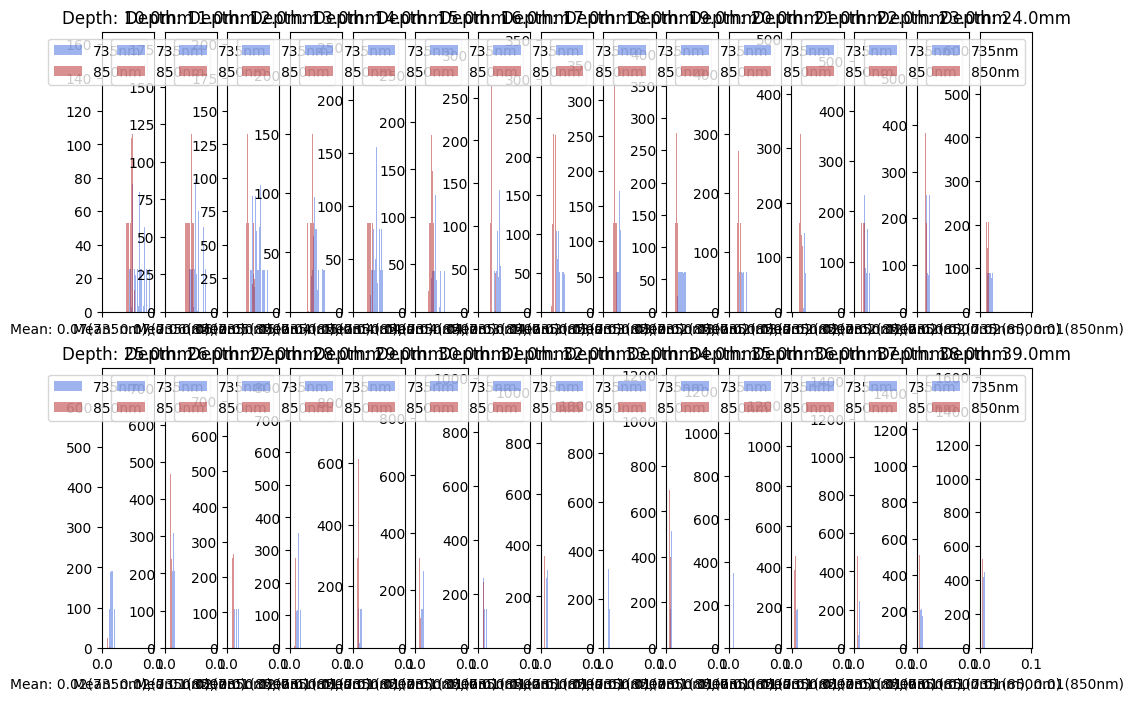

In [12]:
depth_effect_fig1, mean_var_dist_fig1 = plot_depth_specific_distribution(0)

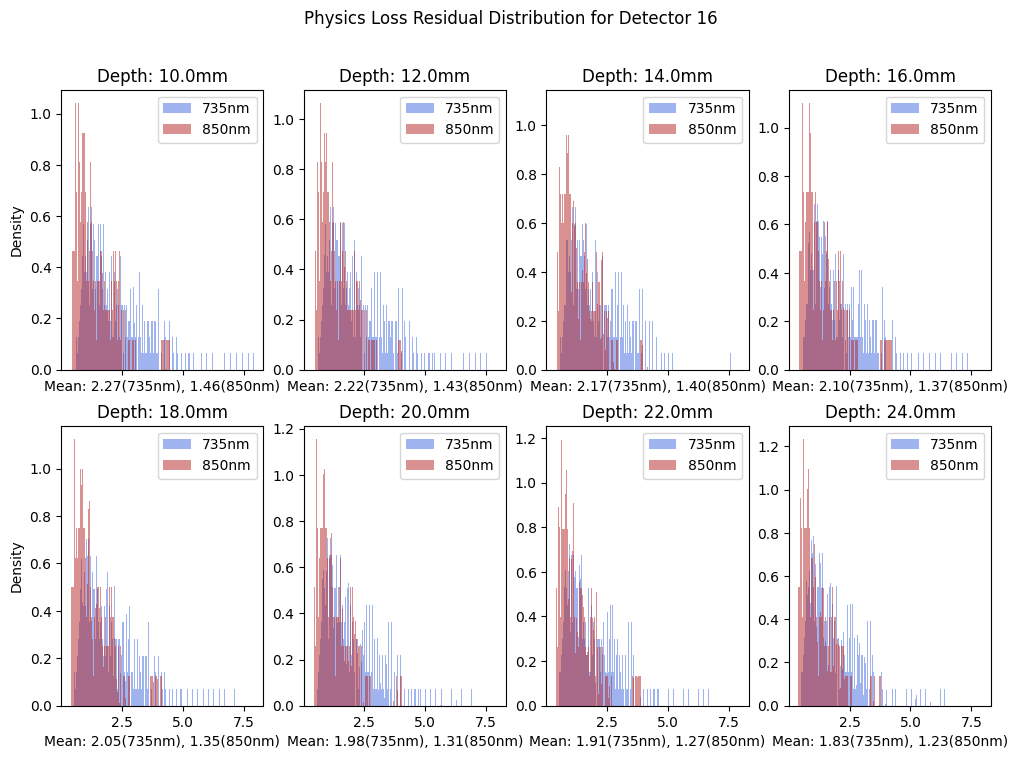

<Figure size 1000x500 with 0 Axes>

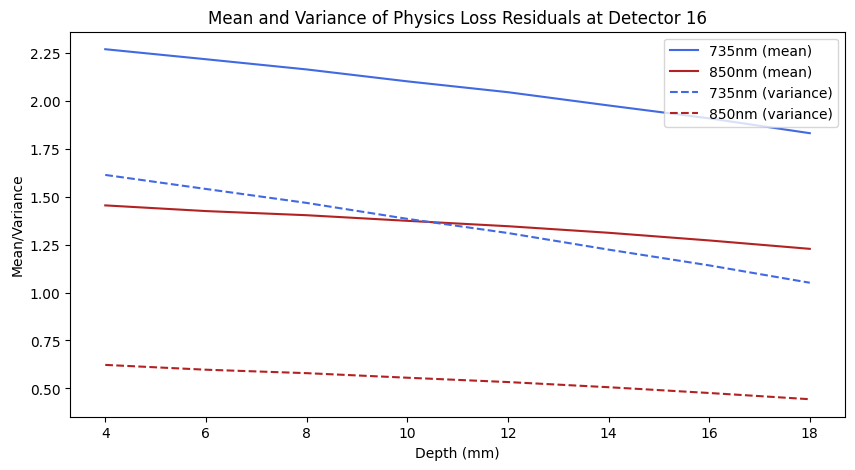

In [ ]:
depth_effect_fig2, mean_var_dist_fig2 = plot_depth_specific_distribution(15)

In [ ]:
all_fetal_conc = data["Fetal Hb Concentration 1"].unique()
all_fetal_conc.sort()
print("Available Fetal Hb Concentrations: ", all_fetal_conc)

Available Fetal Hb Concentrations:  [10.88181818 11.         11.45454545 11.55       11.90909091 12.02727273
 12.36363636 12.50454545 12.81818182 12.98181818 13.27272727 13.45909091
 13.72727273 13.90454545 14.18181818 14.33636364 14.63636364 14.76818182
 15.09090909 15.2        15.54545455 15.84545455 16.32272727 16.8       ]


In [ ]:
def plot_fetal_concentration_specific_distribution(chosen_detector_index: int):
    all_fetal_conc = data["Fetal Hb Concentration 1"].unique()
    all_fetal_conc.sort()
    fetal_effect_fig, axes = plt.subplots(4, len(all_fetal_conc) // 4, figsize=(16, 16), sharex=True, sharey=True)
    axes = axes.flatten()
    means = []
    variances = []
    for index, chosen_fetal in enumerate(all_fetal_conc):
        relevant_rows = data[data["Fetal Hb Concentration 1"] == chosen_fetal].index
        wv2_residuals = (bl_wv2[relevant_rows, chosen_detector_index] - pr_wv2[relevant_rows, chosen_detector_index])
        wv1_residuals = (bl_wv1[relevant_rows, chosen_detector_index] - pr_wv1[relevant_rows, chosen_detector_index])
        axes[index].hist(
            wv1_residuals,
            bins=200,
            density=True,
            alpha=0.50,
            label=f"735nm",
            color="royalblue",
        )
        axes[index].hist(
            wv2_residuals,
            bins=200,
            density=True,
            alpha=0.50,
            label=f"850nm",
            color="firebrick",
        )
        axes[index].set_title(f"Fetal [Hb]: {chosen_fetal:.2f}")
        axes[index].legend(loc="upper right")
        means.append((np.mean(wv1_residuals), np.mean(wv2_residuals)))
        variances.append((np.var(wv1_residuals), np.var(wv2_residuals)))

    # Place Legend
    left_edges = [0, len(all_fetal_conc) // 4, len(all_fetal_conc) // 2, 3 * len(all_fetal_conc) // 4]
    for left_edge in left_edges:
        axes[left_edge].set_ylabel("Density")
    plt.suptitle(f"Physics Loss Residual Distribution for Fetal [Hb] at Detector {chosen_detector_index + 1}")

    # Plot the means and variances
    mean_var_dist_fig = plt.figure(figsize=(10, 5))
    mean_wv1 = [x[0] for x in means]
    mean_wv2 = [x[1] for x in means]
    variance_wv1 = [x[0] for x in variances]
    variance_wv2 = [x[1] for x in variances]
    mean_var_dist_fig = plt.figure(figsize=(10, 5))
    plt.plot(mean_wv1, label="735nm (mean)", color="royalblue")
    plt.plot(mean_wv2, label="850nm (mean)", color="firebrick")
    plt.plot(variance_wv1, label="735nm (variance)", color="royalblue", linestyle="--")
    plt.plot(variance_wv2, label="850nm (variance)", color="firebrick", linestyle="--")
    plt.legend()
    plt.xlabel("Fetal Hb Concentration")
    plt.ylabel("Mean or Variance")
    return fetal_effect_fig, mean_var_dist_fig

(<Figure size 1600x1600 with 24 Axes>, <Figure size 1000x500 with 1 Axes>)

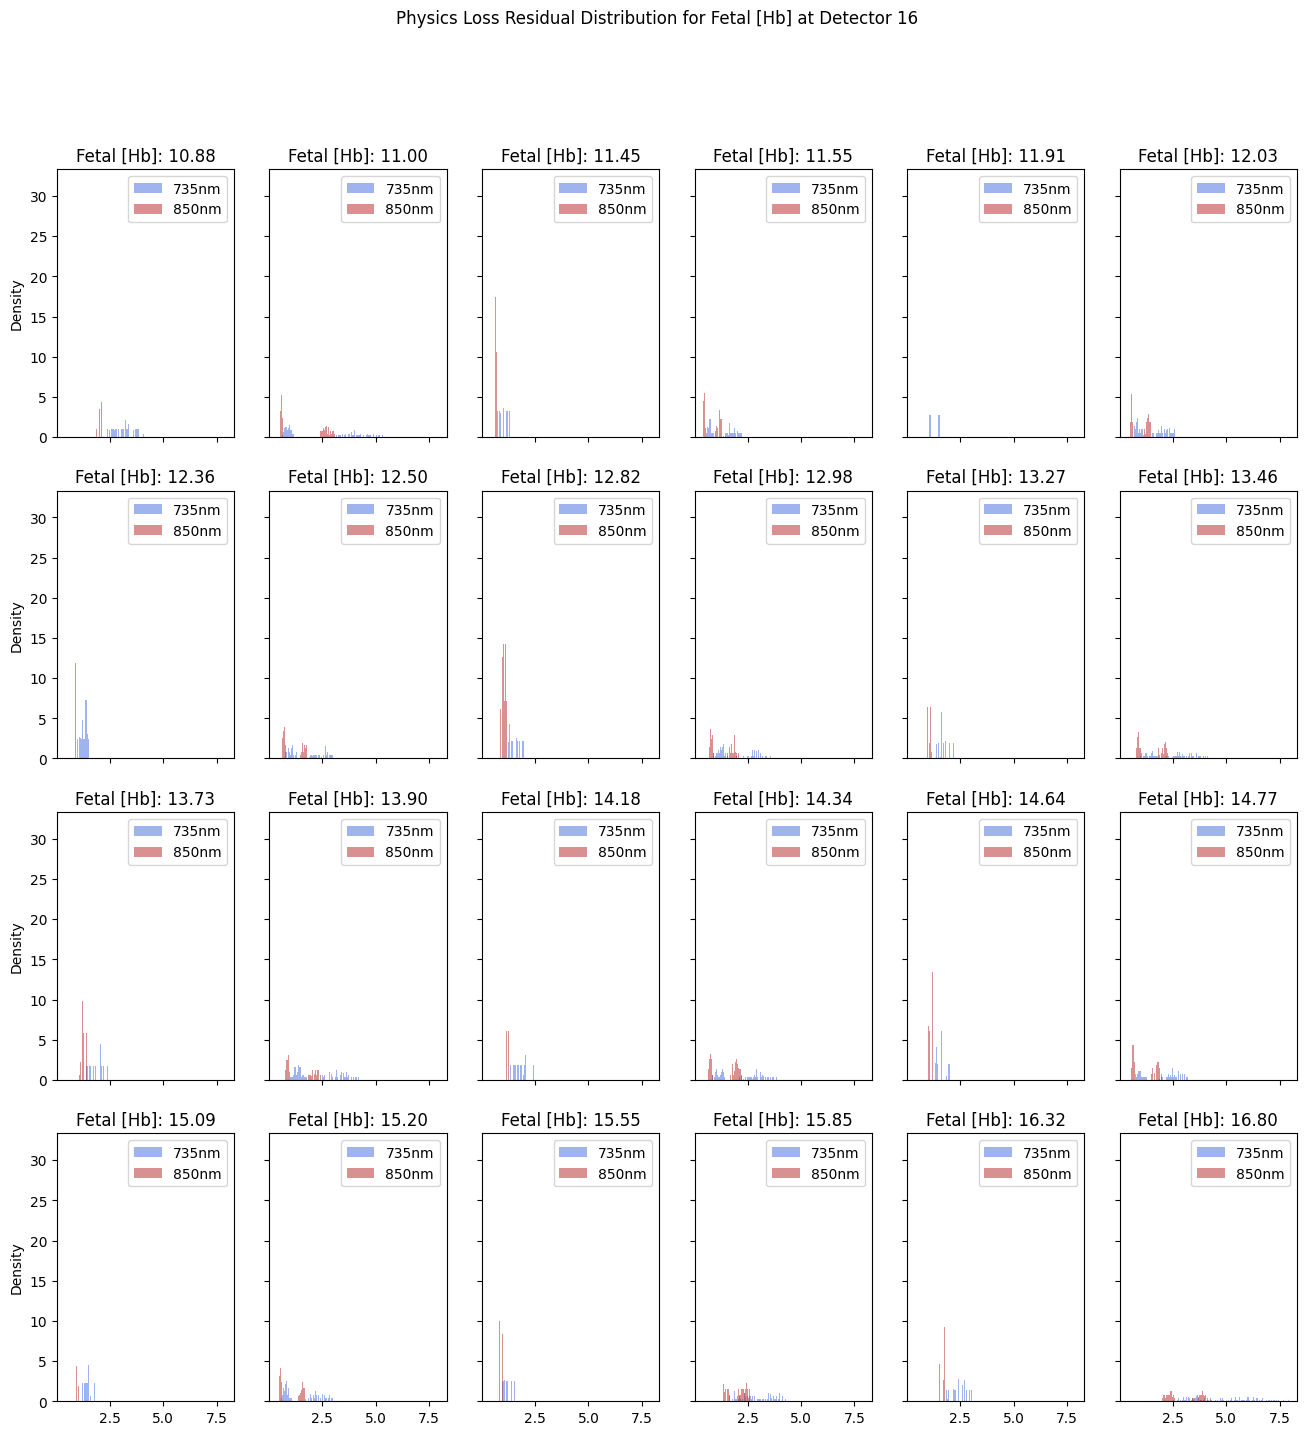

<Figure size 1000x500 with 0 Axes>

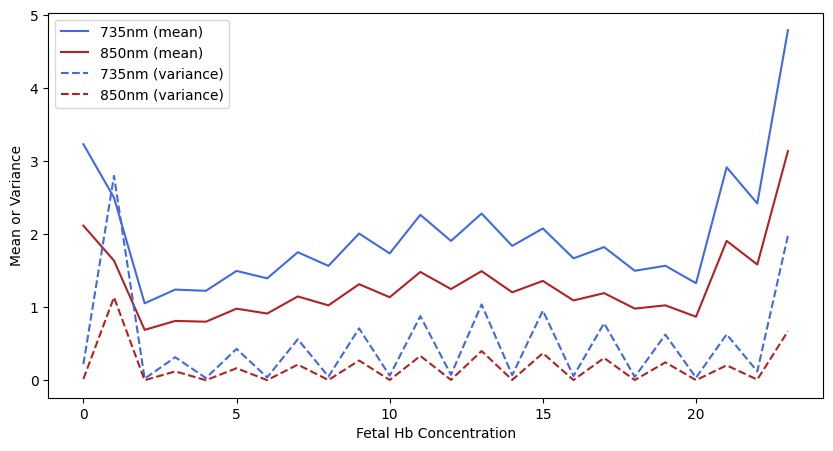

In [ ]:
plot_fetal_concentration_specific_distribution(15)

(<Figure size 1600x1600 with 24 Axes>, <Figure size 1000x500 with 1 Axes>)

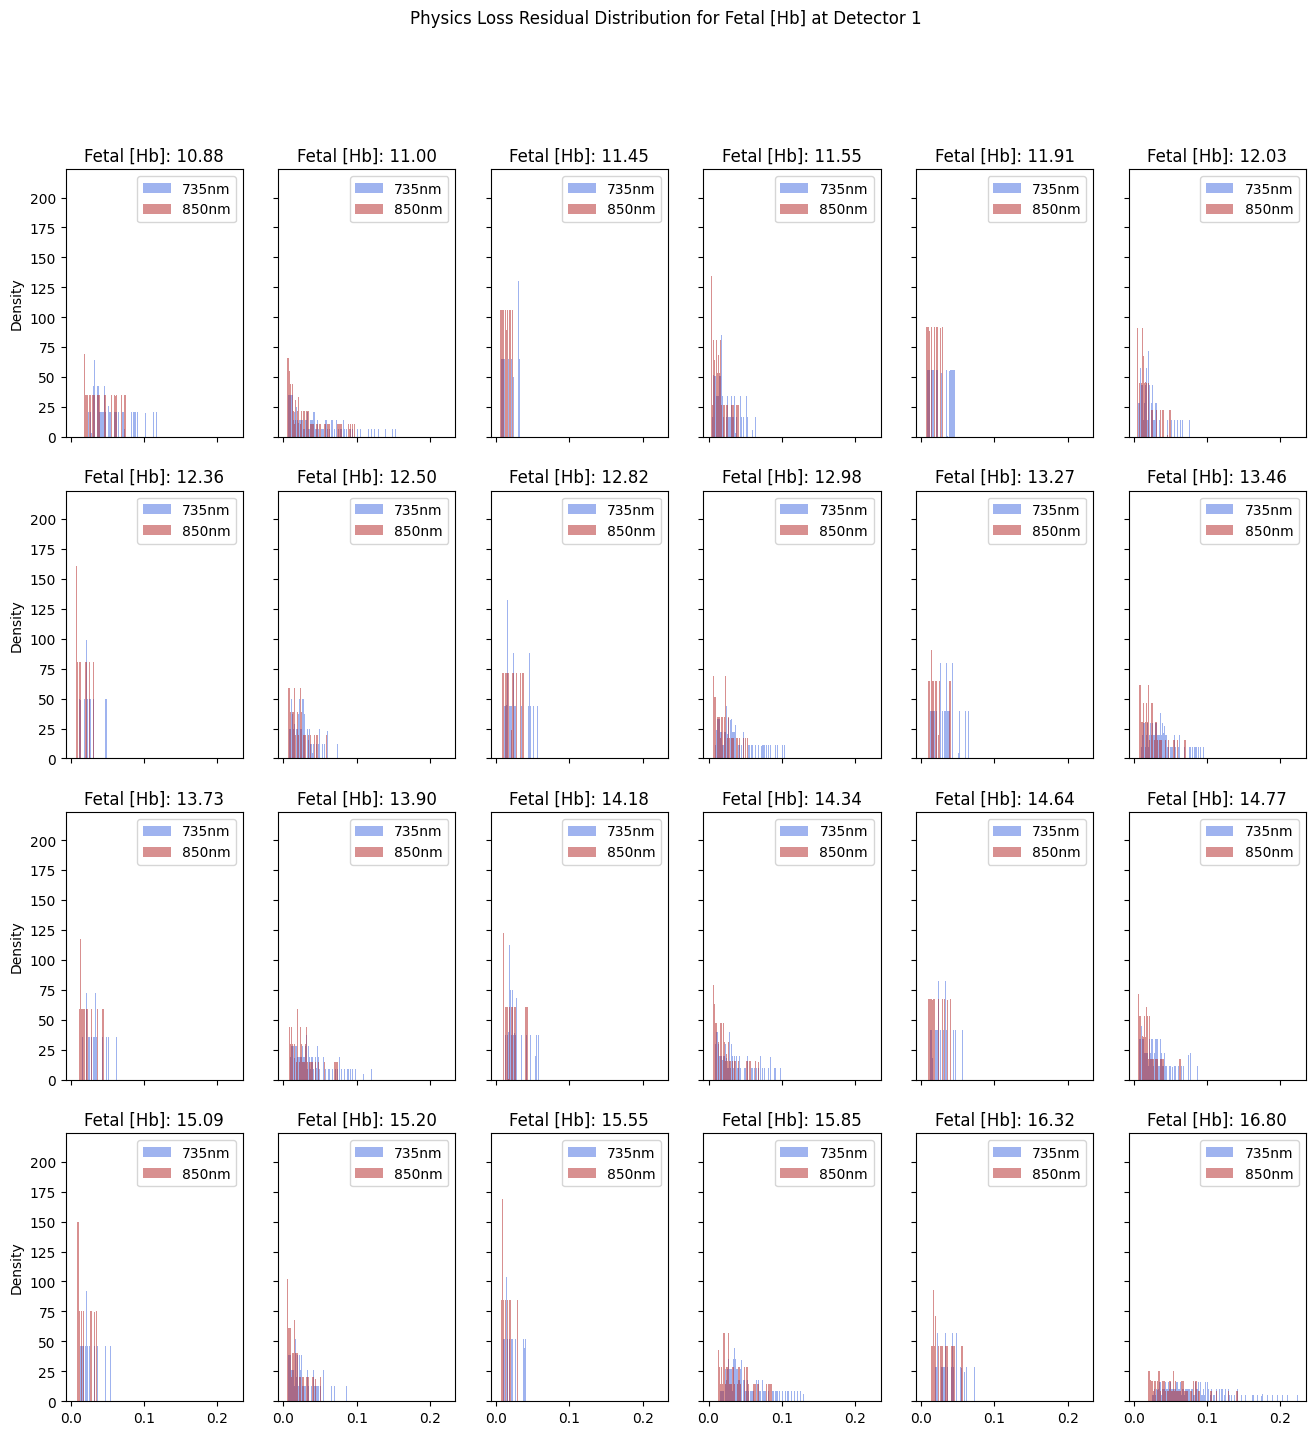

<Figure size 1000x500 with 0 Axes>

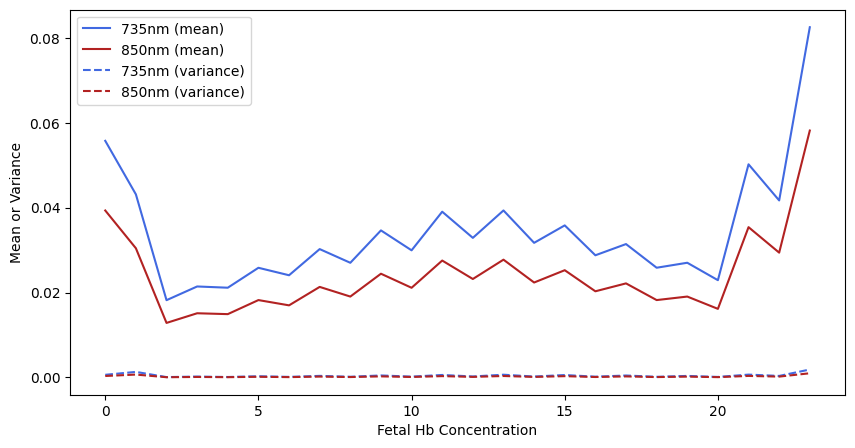

In [ ]:
plot_fetal_concentration_specific_distribution(0)

# Using A Slightly Less Simplified Apporximation
The following euqation assumes that pathlength distribution per layer is independent of each other(Which is not exactly true. But for now, should serve as a valid assumption since I already have the distribution for fetal layer, $p(L_f)$)
$$
PR = log(I_1) - log(I_2) = log(1 - \mu_1 <L_f> + \frac{\mu_1^2}{2!}<L_f^2> - \frac{\mu_1^3}{3!}<L_f^3> + .. ) - log(1 - \mu_2 <L_f> + \frac{\mu_2^2}{2!}<L_f^2> - \frac{\mu_2^3}{3!}<L_f^3> + .. )
$$
Where, the $< >$ stands for expected value with respect to $L_f$. 
(The derivation is in my notes, in PINN, too lazy to type it out on LaTeX)  

In the previous approximations, we assumed $\mu_1 <L_f>$ to be small enough such that we could approximate log(1+x) as x. With the rest of terms just ignored out. Now, the real issue here is that L is actually quite large. (Also, note that both $\mu_a$ and L needs to have similar units. I assume them as mm inverse and mm. The product should ultimately be unitless.). For example, here's how the mean $L_f$ looks like

In [ ]:
data['L4 ppath_mean_77 WV1'].describe()

count    497664.000000
mean       1849.811628
std         127.917339
min        1641.092001
25%        1756.828687
50%        1858.070519
75%        1951.131294
max        2032.930463
Name: L4 ppath_mean_77 WV1, dtype: float64

For a detector at 7.7cm, the mean is around ~2k. Whereas $\mu_a$ is in the range of 0.04 to 0.05. Their product is never going to be a small number. Which makes the above approximation invalid.  
So, now the question becomes how close can we get if we use more and more terms from the above equation. As in, how many moments would we need?   
In the next section, lets remove the $log(1+x) \approx x$ and keep the first two terms only

In [ ]:
# Plot per detector
modified_bl_column_names = [f'{column}_BLM WV1' for column in l4_mean_column_names] + [f'{column}_BLM WV2' for column in l4_mean_column_names]
modified_bl_df = pd.DataFrame(columns=modified_bl_column_names)
for wv1_column, wv2_column, column in zip(wv1_ppath, wv2_ppath, l4_mean_column_names):
    modified_bl_df[f'{column}_BLM WV1'] = np.log(1 - data[wv1_column] * data['Fetal Mua 0 WV1']) - np.log(1 - data[wv1_column] * data['Fetal Mua 1 WV1'])
    modified_bl_df[f'{column}_BLM WV2'] = np.log(1 - data[wv2_column] * data['Fetal Mua 0 WV2']) - np.log(1 - data[wv2_column] * data['Fetal Mua 1 WV2'])
data = pd.concat([data, modified_bl_df], axis=1)

/home/rraiyan/cybercat/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
blm_wv1 = data[list(filter(lambda x: x.endswith('BLM WV1'), data.columns))].to_numpy()
blm_wv2 = data[list(filter(lambda x: x.endswith('BLM WV2'), data.columns))].to_numpy()
blm_wv1 = np.abs(blm_wv1)
blm_wv2 = np.abs(blm_wv2)

loss_breakdown_fig2, axes = plt.subplots(2, 10, figsize=(20, 20), sharex=True)
for i, ax in enumerate(axes.flatten()):
    ax.hist((blm_wv1[:, i] - pr_wv1[:, i]), bins=100, density=True, alpha=0.75, color='royalblue', label='735nm')
    ax.hist((blm_wv2[:, i] - pr_wv2[:, i]), bins=100, density=True, alpha=0.75, color='firebrick', label='850nm')
    ax.set_title(f'Detector {i + 1}')
    ax.legend(loc='upper right')

# Place Legend
axes[0, 0].set_ylabel('Density')
axes[1, 0].set_ylabel('Density')
loss_breakdown_fig.text(0.5, 0.04, r'$Modified Physics Loss Residual With Logs$', ha='center')
plt.tight_layout()